# Лекция №8. Линейная регрессия.

Гипотеза: Имеется линейная статистическая зависимость между переменными X и Y:  
Y = a + bX
Необходимо найти a и b. Значения a и b рассчитываются по методу наименьших квадратов, т.е. так, чтобы минимизировать величину:
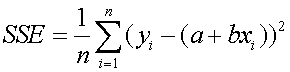

Показателем качества регрессионной модели также выступает коэффициент детерминации. Он отображает, какой процент дисперсии от данных описывается полученной моделью. Коэффициент детерминации рассчитывается по следующей формуле:
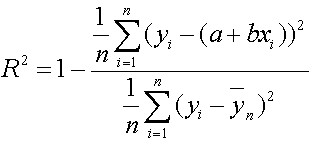

Существуют исследования по недостаткам линейных моделей и описания их коэффициентом детерминации в частности. Примером является **квартет Анскомба**. Вкратце, он показывает, что в случае нелинейных моделей или выбросов применение линейной регрессии может дать высокий показатель коэффициента детерминации, хотя это не будет иметь никакого смысла.

Также при использовании линейной регрессии важно следить за тем, чтобы предикторы были **линейно независимы между собой**. В случае наличия линейной зависимости между предикторами, один из зависимых стоит исключать для улучшения качества модели.

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

### Линейная регрессия с несколькими предикторами

Будем рассматривать предсказание цены домов в Альбукерке.

#### Предварительная обработка данных

In [2]:
df = pd.read_csv('Albuquerque Home Prices.txt', sep='\t')
df = df.replace(-9999, np.nan)
df.head()

,PRICE,SQFT,AGE,FEATS,NE,CUST,COR,TAX
0,2050,2650,13.0,7,1,1,0,1639.0
1,2080,2600,NaN,4,1,1,0,1088.0
2,2150,2664,6.0,5,1,1,0,1193.0
3,2150,2921,3.0,6,1,1,0,1635.0
4,1999,2580,4.0,4,1,1,0,1732.0


Прежде, чем строить модель, нужно решить вопрос с пропущенными значениями. Сначала посчитаем, сколько строчек их содержат.

In [3]:
print('Rows in the data frame: {0}'.format(len(df)))
print('Rows without NAN: {0}'.format(len(df.dropna(how='any'))))

Rows in the data frame: 117
Rows without NAN: 66


Таким образом, около половины наших данных содержат хотя бы одно пропущенное значение. Учитывая то, что данных относительно мало, выбрасывать все такие строчки, было бы слишком расточительно.

Попробуем копнуть глубже и посмотреть на распределение пропущенных значений по колонкам.

Функция ```DataFrame.apply``` применяет указанную функцию ко всей таблице. Первый аргумент -- применяемая функция, второй аргумент -- направление её применения (0 -- применить к колонкам, 1 -- ко строчкам).

In [4]:
df.apply(lambda x: sum(x.isnull()), axis=0)

PRICE     0
SQFT      0
AGE      49
FEATS     0
NE        0
CUST      0
COR       0
TAX      10
dtype: int64

Для определения функции здесь использовано так называемое лямбда-выражение (лямбда-функция). Это способ записать короткую функцию в одну строчку, не задавая её имени. В данном случае такое лямбда-выражение эквивалентно следующему определению функции:

`
def f(x):
    return sum(x.isnull())
`

Таким образом, видим, что источниками пропущенных значений являются колонки ```AGE``` и ```TAX```. Раз в колонке ```AGE``` так много пропусков, то проще её будет убрать из анализа, чем пытаться заделать эти дырки.

In [5]:
del df['AGE']

А колонку ```TAX``` можно попробовать починить. Чтобы это сделать, сначала посмотрим, как выглядит распределение этой колонки.

<AxesSubplot:>

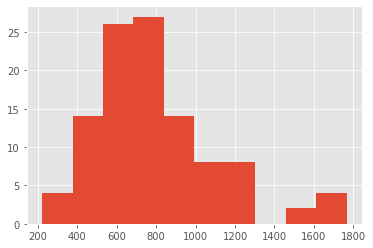

In [6]:
df['TAX'].hist()

Раз распределение похоже на нормальное, то можно заменить пропуски на среднее значение этой колонки. Для этого в pandas есть функция ```Series.fillna```, которая заменяет все пропущенные в колонке значения на заданное.

In [7]:
df['TAX'] = df['TAX'].fillna(df['TAX'].mean())

Убедимся, что все проблемы с пропусками устранены. Длина таблицы с пропусками равна длине исходного датасета.

In [8]:
len(df.dropna())

117

#### Построение модели

In [9]:
X = df.drop('PRICE', axis=1)
y = df['PRICE']
model = LinearRegression()
model.fit(X, y)

LinearRegression()

Считаем качество модели (коэффициент $R^2$).

In [10]:
print('R^2: {0}'.format(model.score(X, y)))

R^2: 0.8022436103807492


Выведем регрессионные коэффициенты от метода model.coef_ и свободный член от метода model.intercept_.

In [11]:
coef = pd.DataFrame(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist()),
                    columns=['predictor', 'coef'])
coef

,predictor,coef
0,intercept,83.175919
1,SQFT,0.291978
2,FEATS,12.176743
3,NE,8.011604
4,CUST,133.014342
5,COR,-65.800841
6,TAX,0.541942


#### Функция расчета p-value коэффициентов линейной регрессии

К сожалению, в ```sklearn``` не предусмотрена процедура определения статистической значимости регрессионных коэффициентов. Поэтому нужно это делать либо руками, вооружившись знанием о распределении коэффициентов, либо воспользовавшись моделью из пакета ```statsmodels```.

In [12]:
def regression_coef(model, X, y):
    coef = pd.DataFrame(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist()),
                    columns=['predictor', 'coef'])
    X1 = np.append(np.ones((len(X),1)), X, axis=1)
    b = np.append(model.intercept_, model.coef_)
    MSE = np.sum((model.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
    var_b = MSE * (np.linalg.inv(np.dot(X1.T, X1)).diagonal())
    sd_b = np.sqrt(var_b)
    t = b / sd_b
    coef['pvalue'] = [2 * (1 - stats.t.cdf(np.abs(i), (len(X1) - 1))) for i in t]
    return coef
regression_coef(model, X, y)

,predictor,coef,pvalue
0,intercept,83.175919,1.895059e-01
1,SQFT,0.291978,2.580075e-06
2,FEATS,12.176743,3.419172e-01
3,NE,8.011604,8.190403e-01
4,CUST,133.014342,3.454095e-03
5,COR,-65.800841,1.168611e-01
6,TAX,0.541942,4.972770e-07


#### Анализ результатов

Как интерпретировать модель? У нас есть 3 значимых предиктора: ```SQFT```, ```CUST``` и ```TAX```.  Значение коэффициента говорит, на сколько вырастет значение сигнала при увеличении предиктора на одну единицу. Смысл первых двух коэффициентов понятен: площадь и специальный вид постройки ожидаемо влияют на цену. Но есть ли смысл включать в предсказание цены дома налог с этого же дома? Ведь налог, как и цена, также начисляется исходя из похожих предикторов. Они должны сильно коррелировать. И действительно. Построим таблицу парных корреляций предикторов.

In [13]:
df.corr()

,PRICE,SQFT,FEATS,NE,CUST,COR,TAX
PRICE,1.000000,0.844795,0.420272,0.167840,0.555292,-0.079293,0.844889
SQFT,0.844795,1.000000,0.394925,0.145030,0.520102,0.040528,0.832674
FEATS,0.420272,0.394925,1.000000,0.190016,0.241964,-0.041547,0.419473
NE,0.167840,0.145030,0.190016,1.000000,0.043033,-0.077336,0.189230
CUST,0.555292,0.520102,0.241964,0.043033,1.000000,-0.003994,0.444906
COR,-0.079293,0.040528,-0.041547,-0.077336,-0.003994,1.000000,-0.058329
TAX,0.844889,0.832674,0.419473,0.189230,0.444906,-0.058329,1.000000


Налоги сильно коррелируют с площадью. Предлагается откинуть налоги.

In [14]:
X = df[['SQFT', 'CUST']]
model.fit(X, y)
print(model.score(X, y))
regression_coef(model, X, y)

0.7320966420178658


,predictor,coef,pvalue
0,intercept,114.134824,0.082734
1,SQFT,0.553635,0.000000
2,CUST,142.859931,0.005787


### Полиномиальная регрессия

In [15]:
df = pd.read_csv('diamond.dat', header=None, sep='\s+', names=['weight', 'price'])
df.head()

,weight,price
0,0.17,355
1,0.16,328
2,0.17,350
3,0.18,325
4,0.25,642


Будем предсказывать цену кольца с бриллиантом от веса бриллианта. Попробуем предсказать результат не только с помощью самой переменной, но и с помощью её степеней. Первая модель будет зависеть только от самой переменной ```weight```, вторая -- от переменной ```weight^2```, а третья -- от двух этих переменных сразу.

В этих случаях, когда мы хотим попробовать в качестве фичей их степени и произведения фич, в ```sklearn.preprocessing``` есть класс ```PolynomialFeatures```. Метод ```fit_transform``` этого класса сгенерирует из данного множества фич множество одночленов заданной степени. Например, для степени 2 и фич ```a```, ```b``` будут сгенерированы фичи ```[a, b, a^2, b^2, ab]```, а при указанном параметре ```include_bias=True``` ещё и вектор-свободный член из единиц. Для данной задачи, конечно, проще было сгенерить один столбец из квадратов значений колонки ```weight```. Но нам важно ознакомиться с классом ```PolynomialFeatures``` для дальнейшего применения.

In [16]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(
                          # Максимальная степень
                          degree=2,
                          # Не генерировать свободный член
                          include_bias=False)
y = df['price']
X0 = poly.fit_transform(df[['weight']])
X0 = pd.DataFrame(X0, columns=['weight', 'weight^2'])
X0.head()

,weight,weight^2
0,0.17,0.0289
1,0.16,0.0256
2,0.17,0.0289
3,0.18,0.0324
4,0.25,0.0625


In [17]:
X0 = [
    # Одна оригинальная переменная weight
    X0[['weight']],
    # Одна переменная weight^2
    X0[['weight^2']],
    # Две переменных weight и weight^2
    X0.copy()]
models = [LinearRegression() for _ in X0]

In [18]:
for X, model in zip(X0, models):
    model.fit(X, y)
    print(model.score(X, y))

0.978260777986033
0.970310818417109
0.9789175801893899


Получилось, что $R^2$ во всех моделях примерно одинаков. Однако не все они одинаково полезны. 

In [19]:
regression_coef(models[0], X0[0], y)

,predictor,coef,pvalue
0,intercept,-259.625907,0.0
1,weight,3721.024852,0.0


In [20]:
regression_coef(models[1], X0[1], y)

,predictor,coef,pvalue
0,intercept,141.659045,0.0
1,weight^2,7993.108083,0.0


In [21]:
regression_coef(models[2], X0[2], y)

,predictor,coef,pvalue
0,intercept,-174.130082,0.021866
1,weight,2920.130591,0.000077
2,weight^2,1739.901579,0.237265


В 1-й и 3-й моделях свободный член отрицательный, что логически неверно: при нулевом весе бриллианта в кольце нам должны еще и доплатить при его покупке???  
Также в 3-й модели p-value для коэффициента при 2-й степени получилось выше любого принятого уровня значимости. Получается, что в комбинированной модели с 1-й и 2-й степенями последняя становится статистически не значимой, что странно, учитывая, что во 2-й модели 2-я степень - значима. Эта ситуация объясняется тем, что при наблюдаемых значениях веса (которые малы), которые использованы для модели, линейная и квадратичная зависимости очень близки между собой и "воспринимаются" моделью как линейно зависимые, что сказывается на качестве модели.